# dominating set

Set up calculations and store in EspressoDB

In [3]:
import matplotlib.pylab as plt
import seaborn as sns
import os

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import (
    graph_summary,
    experiment_summary,
    data_summary,
    insert_result,
    QUBO_to_Ising,
    retry_embedding,
    find_offset,
    AnnealOffset,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler
from minorminer import find_embedding
from dwave.system.composites import EmbeddingComposite, FixedEmbeddingComposite

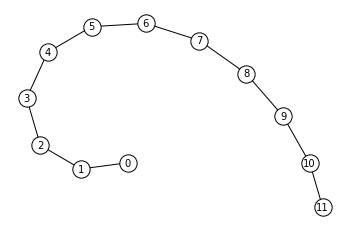

{'tag': 'NN(12)', 'total_vertices': 12, 'total_edges': 11, 'total_qubits': 34, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [7, 8], [6, 7], [10, 11], [4, 5], [5, 6], [8, 9], [9, 10], [2, 3], [3, 4]], 'adjacency_hash': 'dbd1a76bf1a75962a27b59794f9a3249'}
Greedy solution
 {0, 2, 4, 6, 8, 10}
Solving 1/50
0.0801198070633592Not enough offset range for inhomogeneous driving. Try another embedding.

0.03239910683531393Not enough offset range for inhomogeneous driving. Try another embedding.

0.0563095113207886Not enough offset range for inhomogeneous driving. Try another embedding.

0.09034689718085795Not enough offset range for inhomogeneous driving. Try another embedding.

0.07787582198549016Not enough offset range for inhomogeneous driving. Try another embedding.

0.04839395735919256Not enough offset range for inhomogeneous driving. Try another embedding.
Solving 2/50
0.029338773341475013Not enough offset range for inhomogeneous driving. Try another embedding.

0.039792261203782Not enoug


0.09107612740885085Not enough offset range for inhomogeneous driving. Try another embedding.

0.013993025405575413Not enough offset range for inhomogeneous driving. Try another embedding.

0.03962547692902392Not enough offset range for inhomogeneous driving. Try another embedding.

0.09107612740885085Not enough offset range for inhomogeneous driving. Try another embedding.

0.04301802874540578Not enough offset range for inhomogeneous driving. Try another embedding.

0.037262649106276094Not enough offset range for inhomogeneous driving. Try another embedding.
Solving 30/50
0.06931261570357312Not enough offset range for inhomogeneous driving. Try another embedding.

0.02410667136977718Not enough offset range for inhomogeneous driving. Try another embedding.

0.027301562647591694Not enough offset range for inhomogeneous driving. Try another embedding.

0.09295571825515302Not enough offset range for inhomogeneous driving. Try another embedding.

0.041298860571148004Not enough offset range

In [ ]:
# Define Adjacency matrix
# graph, tag = gt.generate_nn_graph(v)
# graph, tag = gt.generate_hamming_graph(d, v)
# graph, tag = gt.generate_bipartite_graph(p, q)
# graph, tag = gt.generate_newman_watts_strogatz_graph(v, n, p)
# graph, tag = gt.generate_corona_graph(k, n)

# Define anneal offset
# "constant": no offset
# "linear": linear with respect to |h|

for nvertices in range(12, 13):
    """User defined inputs"""
    # Define graph
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2
    # Set functional form of anneal offset
    offsetcls = AnnealOffset("constant")
    # DWave parameters
    annealing_time = 500  # integer microseconds [1, 2000]
    answer_mode = "raw"  # histogram or raw
    auto_scale = True
    num_reads = 1000  # raw will dump out all results
    num_spin_reversal_transforms = 0
    readout_thermalization = 0  # default 0
    programming_thermalization = 1000  # default 1000
    # Iterate for more statistics
    iterations = 50
    insertdb = True

    """Start program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    q_min = np.array(list(qubo.values())).min()

    # plot graph
    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph, qubo)
    print(graph_params)

    # greedy solution
    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))

    # convert to Ising
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))

    # Set chain strength
    chain_strength = maxJ * 2

    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)

    qpu_graph = sampler.edgelist
    qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}

    for idx in range(iterations):
        print(f"\rSolving {idx+1}/{iterations}", end="")
        embed, embedding, min_offset, max_offset = retry_embedding(
            sampler, qubo_dict, qpu_graph, 100
        )
        anneal_offsets, exp_tag = find_offset(
            h=h,
            fcn=offsetcls.fcn,
            embedding=embedding,
            min_offset=min_offset,
            max_offset=max_offset,
        )
        dwave_config = {
            "annealing_time": annealing_time,  # integer microseconds [1, 2000]
            "answer_mode": answer_mode,  # histogram or raw
            "auto_scale": auto_scale,
            "num_reads": num_reads,  # raw will dump out all results
            "num_spin_reversal_transforms": num_spin_reversal_transforms,
            "readout_thermalization": readout_thermalization,  # default 0
            "programming_thermalization": programming_thermalization,  # default 1000
            "chain_strength": chain_strength,
            "anneal_offsets": anneal_offsets,
        }

        experiment_params = experiment_summary(
            machine=solver,
            settings=dwave_config,
            penalty=penalty,
            chain_strength=chain_strength,
            tag=exp_tag,
        )

        # Solve on DWave and push to database
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        if insertdb:
            result = insert_result(graph_params, experiment_params, data_params)
print("\nDONE")